# 1. Build an image segmentation model using pytorch

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

In [2]:
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            # nn.Dropout(0.5),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        return self.conv(x)

In [3]:
class UNet(nn.Module):
    def __init__(self, in_channel =3, out_channel = 1, features= [64,128,256,512],):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.up = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        # down sampling
        for feature in features:
            self.downs.append(Conv(in_channel, feature))
            in_channel = feature
        # up sampling
        for feature in reversed(features):
            self.up.append(
                nn.ConvTranspose2d(feature*2,feature,kernel_size=2, stride =2)
            )
            self.up.append(Conv(feature*2, feature))
        self.bottleneck = Conv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channel,kernel_size=1)
    def forward(self,x):
        skip_connection =[]
        for down in self.downs:
            x = down(x)
            #print("ups: ", x.shape)
            skip_connection.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connection = skip_connection[::-1]


        for idx in range(0,len(self.up),2):
            x = self.up[idx](x)
            #print("in",skip_connection[4//2].shape)
            skip_connections = skip_connection[idx//2]
            #print("skip: ",skip_connection.shape)
            if x.shape != skip_connections.shape:
                x = TF.resize(x,size= skip_connections.shape[2:])
            #print(skip_connection.shape,x.shape)
            concat_skip = torch.cat((skip_connections,x), dim=1) #[batch, height, width]4
            #print("c: ",concat_skip.shape)
            x = self.up[idx+1](concat_skip)
            #print("test: ",x.shape)
        return self.final_conv(x)



In [4]:
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [6]:
train_image_path = "/content/drive/MyDrive/New folder/Lung_segmentation/Train/Images"
train_mask_path = "/content/drive/MyDrive/New folder/Lung_segmentation/Train/Masks"


In [7]:
class customdataset(Dataset):
    def __init__(self, image_path, mask_path, transform = None):
        self.images = image_path
        self.mask = mask_path
        self.transform = transform


        self.image_file_path = sorted(os.listdir(self.images))
        self.mask_file_path = sorted(os.listdir(self.mask))
    def __len__(self):
        return len(self.image_file_path)

    def __getitem__(self,idx):
        each_image_path = os.path.join(self.images,self.image_file_path[idx])
        each_mask_path = os.path.join(self.mask,self.mask_file_path[idx])
        image = np.array(Image.open(each_image_path).convert("RGB"))
        mask = np.array(Image.open(each_mask_path).convert("L"),dtype= np.float32)
        mask[mask == 255.0] = 1.0
        if self.transform is not None:
            augmentations = self.transform(image = image, mask = mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
        return image, mask

In [8]:
transform = A.Compose([
    A.Resize(height=256, width=256),
    # Add more augmentations as needed
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=0.5),
    # A.Transpose(p=0.5),
    # A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    # A.RandomBrightnessContrast(p=0.5),
    # A.RandomGamma(p=0.5),
    ToTensorV2(),
])

In [9]:
TrainDataset = customdataset(train_image_path, train_mask_path, transform=transform)

train_dataloader = DataLoader(TrainDataset, batch_size=4, shuffle=True)


# 2. Train your model using [lung segmentation datasets](https://github.com/YoushanZhang/Lung_Segmentation)

torch.Size([4, 256, 256]) torch.Size([4, 3, 256, 256])


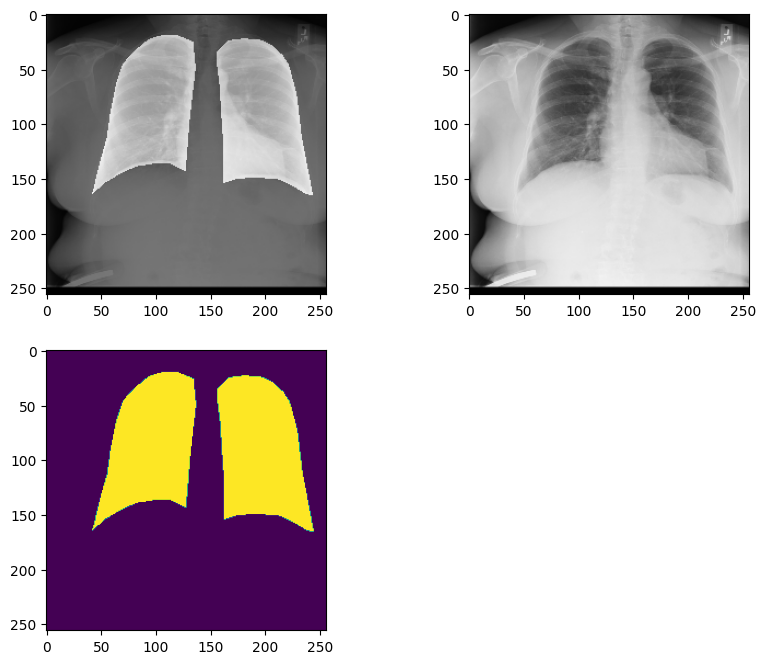

In [10]:
for batch in train_dataloader:
    i,m = batch
    print(m.size(),i.size())
    image1 = transforms.ToPILImage()(m[1])
    image2 = transforms.ToPILImage()(i[1])
    overlapped_image = Image.blend(image1.convert('RGBA'), image2.convert('RGBA'), alpha=0.5)
    plt.figure(figsize=(10,8))
    plt.subplot(2,2,1)
    plt.imshow(overlapped_image)
    plt.subplot(2,2,2)
    plt.imshow(image2)
    plt.subplot(2,2,3)
    plt.imshow(image1)
    plt.show()
    break


In [11]:
model = UNet()
model

UNet(
  (downs): ModuleList(
    (0): Conv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): Conv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )

In [12]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.0001)

In [13]:
epochs = 10
gpu = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gpu

device(type='cuda')

In [14]:
model = model.to(torch.float32)
model= model.to(gpu)

In [15]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, masks in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs}'):
        inputs, masks = inputs.to(torch.float32), masks.to(torch.float32)
        inputs, masks = inputs.to(gpu), masks.to(gpu)
        optimizer.zero_grad()
        outputs = model(inputs)
        masks = masks.unsqueeze(1)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/10: 100%|██████████| 200/200 [01:08<00:00,  2.93it/s]


Epoch 1/10, Loss: 0.3105


Epoch 2/10: 100%|██████████| 200/200 [01:06<00:00,  3.03it/s]


Epoch 2/10, Loss: 0.2041


Epoch 3/10: 100%|██████████| 200/200 [01:05<00:00,  3.05it/s]


Epoch 3/10, Loss: 0.1628


Epoch 4/10: 100%|██████████| 200/200 [01:05<00:00,  3.04it/s]


Epoch 4/10, Loss: 0.1384


Epoch 5/10: 100%|██████████| 200/200 [01:05<00:00,  3.04it/s]


Epoch 5/10, Loss: 0.1201


Epoch 6/10: 100%|██████████| 200/200 [01:05<00:00,  3.04it/s]


Epoch 6/10, Loss: 0.1118


Epoch 7/10: 100%|██████████| 200/200 [01:05<00:00,  3.04it/s]


Epoch 7/10, Loss: 0.0970


Epoch 8/10: 100%|██████████| 200/200 [01:05<00:00,  3.05it/s]


Epoch 8/10, Loss: 0.0899


Epoch 9/10: 100%|██████████| 200/200 [01:05<00:00,  3.05it/s]


Epoch 9/10, Loss: 0.0882


Epoch 10/10: 100%|██████████| 200/200 [01:05<00:00,  3.05it/s]

Epoch 10/10, Loss: 0.0844


In [16]:
model.eval()

UNet(
  (downs): ModuleList(
    (0): Conv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): Conv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )

# 3.Evaluate your model using the test images

In [17]:
test_transform = A.Compose([
    A.Resize(height=256, width=256),
    # Add more augmentations as needed
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=0.5),
    # A.Transpose(p=0.5),
    #A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])

In [18]:
test_image_path = "/content/drive/MyDrive/New folder/Lung_segmentation/Test/Images"
test_mask_path = "/content/drive/MyDrive/New folder/Lung_segmentation/Test/Masks"
print("Total Test image",len(test_image_path))
print("Total Test mask",len(test_mask_path))

Total Test image 63
Total Test mask 62


In [19]:
test_dataset = customdataset(test_image_path, test_mask_path, transform=test_transform)

testdataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

torch.Size([4, 256, 256]) torch.Size([4, 3, 256, 256])


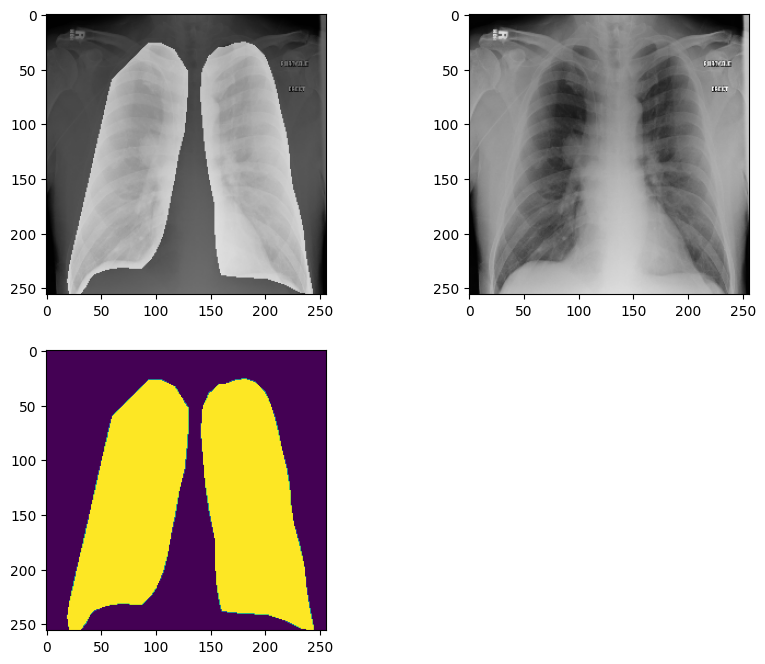

In [20]:
for batch in testdataloader:
    i,m = batch
    print(m.size(),i.size())
    image1 = transforms.ToPILImage()(m[1])
    image2 = transforms.ToPILImage()(i[1])
    overlapped_image = Image.blend(image1.convert('RGBA'), image2.convert('RGBA'), alpha=0.5)
    plt.figure(figsize=(10,8))
    plt.subplot(2,2,1)
    plt.imshow(overlapped_image)
    plt.subplot(2,2,2)
    plt.imshow(image2)
    plt.subplot(2,2,3)
    plt.imshow(image1)
    plt.show()
    break


In [21]:
all_pred=[]
all_labels=[]
running_iou = 0.0

In [22]:
def calculate_iou(predicted_masks, target_masks, threshold=0.7):

    # Binarize predicted masks based on the threshold
    predicted_masks = (predicted_masks > threshold).float()

    # Calculate intersection and union
    intersection = torch.sum(predicted_masks * target_masks)
    union = torch.sum((predicted_masks + target_masks) > 0)

    # Calculate IoU
    iou = intersection / union.float().clamp(min=1e-6)

    return iou.item()

In [23]:
with torch.no_grad():
    for inputs, masks in tqdm(train_dataloader, desc='Evaluating'):
        inputs, masks = inputs.to(torch.float32), masks.to(torch.float32)
        inputs, masks = inputs.to(gpu), masks.to(gpu)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs)
        iou = calculate_iou(preds, masks)
        running_iou += iou
        all_pred.append(preds.cpu().numpy())
        all_labels.append(masks.cpu().numpy())
all_pred = np.concatenate(all_pred)
all_labels = np.concatenate(all_labels)
binary_preds = (all_pred > 0.5).astype(int)
binary_labels = (all_labels > 0.5).astype(int)
accuracy = accuracy_score(binary_labels.flatten(), binary_preds.flatten())
print(f"Accuracy: {accuracy:.4f}")
average_iou = running_iou / len(train_dataloader)
print(f"Average IoU on Evaluation Set: {average_iou:.4f}")

Evaluating: 100%|██████████| 200/200 [00:34<00:00,  5.78it/s]


Accuracy: 0.9719
Average IoU on Evaluation Set: 0.5829


In [25]:


torch.save(model.state_dict(), '/content/drive/MyDrive/New folder/Lung_segmentation/segmentation.pth')


# 4. Your IoU score should be higher than 0.85

My IoU Score is getting 0.5829

# 5. Write a 2-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.


https://drive.google.com/drive/folders/15mF80SZpIoGBIHo6O_SzvgYtR12tNWsC?usp=sharing